In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, boxcox
from kneed import KneeLocator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load datasets
df_medications = pd.read_csv('/content/drive/My Drive/DM/medications.csv', encoding='latin1')
df_demographic = pd.read_csv('/content/drive/My Drive/DM/demographic.csv')
df_diet = pd.read_csv('/content/drive/My Drive/DM/diet.csv', encoding='latin1')
df_labs = pd.read_csv('/content/drive/My Drive/DM/labs.csv', encoding='latin1')

# Filter RXDRSC1 prefixes
prefixes = ('E11', 'E78', 'I10', 'E11.', 'E78.', 'I10.')
df_medications_filtered = df_medications[['SEQN', 'RXDRSC1']].copy()
df_medications_filtered = df_medications_filtered[
    df_medications_filtered['RXDRSC1'].str.startswith(prefixes, na=False)
]

# Group and limit entries
df_medications_filtered = (
    df_medications_filtered.groupby('SEQN')['RXDRSC1']
    .apply(lambda x: list(x[:1]))  # Ensure grouped entries are lists
    .reset_index()
)

# Explode the list into single values
df_medications_filtered = df_medications_filtered.explode('RXDRSC1', ignore_index=True)

# Finalize medication data
df_medications_final = df_medications_filtered.reset_index(drop=True)

columns_to_keep = [
    'SEQN', 'RIAGENDR', 'RIDAGEYR', 'RIDRETH1', 'INDFMPIR',
    'INDHHIN2', 'DMDEDUC2', 'DMDHHSIZ', 'RIDEXPRG',
    'WTINT2YR', 'WTMEC2YR', 'DMDHHSZE', 'DMQMILIZ'
]
df_demographic_filtered = df_demographic[columns_to_keep].copy()

# Modify RIDEXPRG column
df_demographic_filtered.loc[df_demographic_filtered['RIAGENDR'] == 1, 'RIDEXPRG'] = 0
df_demographic_filtered.loc[
    (df_demographic_filtered['RIAGENDR'] == 2) & (df_demographic_filtered['RIDEXPRG'].isna()), 'RIDEXPRG'
] = 3

# Drop rows with missing or zero values
columns_to_check = ['INDFMPIR', 'INDHHIN2', 'DMDEDUC2', 'WTMEC2YR']
df_demographic_filtered.dropna(subset=columns_to_check, inplace=True)
df_demographic_filtered = df_demographic_filtered[
    ~(df_demographic_filtered[columns_to_check] == 0).any(axis=1)
]

# One-hot encode categorical features
categorical_features = ['RIDRETH1', 'RIDEXPRG']
df_encoded = pd.get_dummies(df_demographic_filtered, columns=categorical_features, drop_first=True)
df_encoded = df_encoded.astype(int)

# Filter diet data
diet_columns_to_keep = [
    'SEQN', 'DR1TNUMF', 'DR1TCARB', 'DR1TSFAT', 'DR1TCHOL',
    'DR1TVB6', 'DR1TSUGR', 'DR1TFIBE', 'DR1TCALC', 'DR1TPHOS',
    'DR1TMAGN', 'DR1TIRON', 'DR1TZINC', 'DR1TCOPP', 'DR1TSODI',
    'DR1TPOTA', 'DR1TSELE', 'DR1TCAFF', 'DR1TPROT'
]
df_diet_filtered = df_diet[diet_columns_to_keep].copy()

# Filter lab data
labs_columns_to_keep = [
    'SEQN', 'LBXWBCSI', 'LBDHDD', 'LBXIN', 'LBXTC',
    'LBXBPB', 'LBXBCD', 'LBXBSE'
]
df_labs_filtered = df_labs[labs_columns_to_keep].copy()

# Merge datasets
df_merged = pd.merge(df_encoded, df_medications_final, on='SEQN', how='inner')
df_merged = pd.merge(df_merged, df_diet_filtered, on='SEQN', how='inner')
df_merged = pd.merge(df_merged, df_labs_filtered, on='SEQN', how='inner')

print(df_merged.head())

    SEQN  RIAGENDR  RIDAGEYR  INDFMPIR  INDHHIN2  DMDEDUC2  DMDHHSIZ  \
0  73557         1        69         0         4         3         3   
1  73558         1        54         1         7         3         4   
2  73559         1        72         4        10         4         2   
3  73561         2        73         5        15         5         2   
4  73562         1        56         4         9         4         1   

   WTINT2YR  WTMEC2YR  DMDHHSZE  ...  DR1TSELE  DR1TCAFF  DR1TPROT  LBXWBCSI  \
0     13281     13481         2  ...      62.5     203.0     43.63       4.7   
1     23682     24471         0  ...     715.8     240.0    338.13      12.6   
2     57214     57193         2  ...      98.3      45.0     64.61       7.2   
3     63709     65541         2  ...      68.7      24.0     55.24       6.6   
4     24978     25344         0  ...      84.0     144.0     55.11       9.4   

   LBDHDD  LBXIN  LBXTC  LBXBPB LBXBCD  LBXBSE  
0    65.0    NaN  167.0     NaN    Na

In [ ]:
# Calculate the percentage of null values for each column
null_percentages = df_merged.isnull().mean() * 100

# Display the percentages for columns with null values
print("Percentage of null values in each column:")
null_percentages

Percentage of null values in each column:


,0
SEQN,0.0
RIAGENDR,0.0
RIDAGEYR,0.0
INDFMPIR,0.0
INDHHIN2,0.0
DMDEDUC2,0.0
DMDHHSIZ,0.0
WTMEC2YR,0.0
DMDHHSZE,0.0
DMQMILIZ,0.0


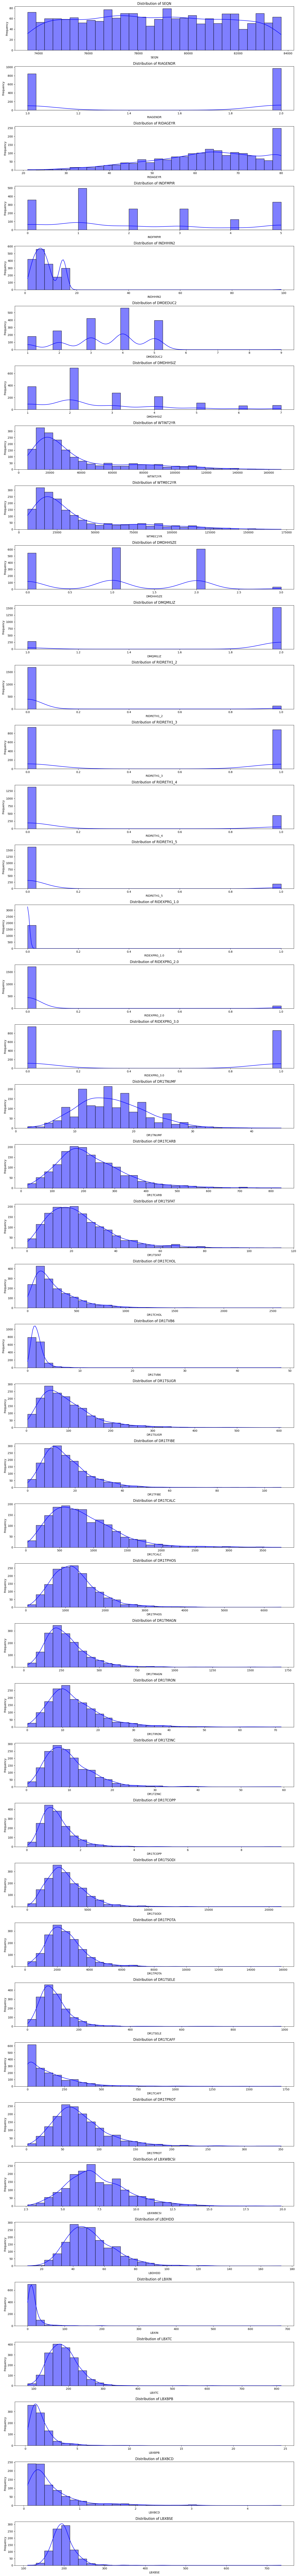

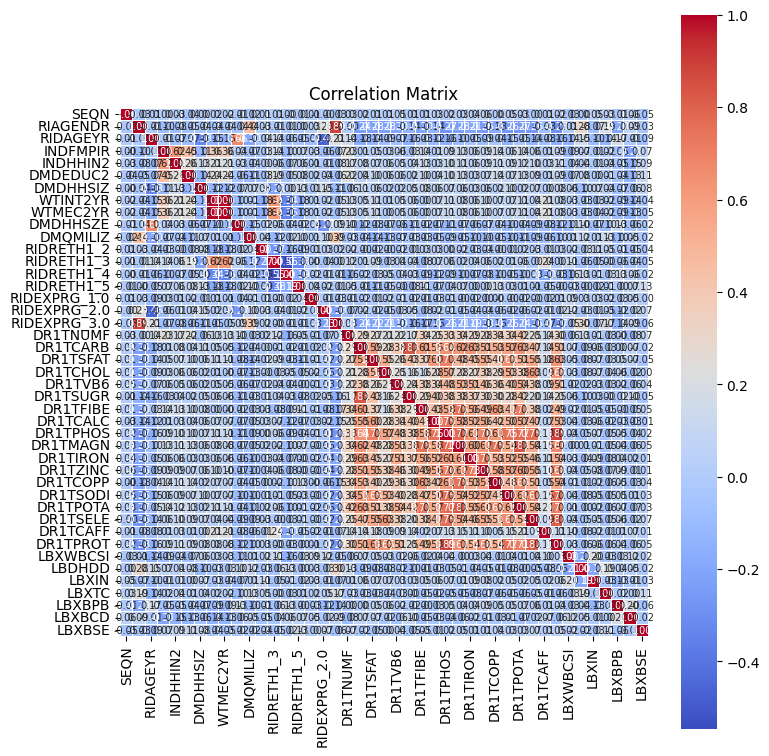

In [ ]:
# distribution plots for numeric features
numeric_columns = df_merged.select_dtypes(include=['number']).columns

plt.figure(figsize=(15, len(numeric_columns) * 3))
for idx, column in enumerate(numeric_columns, 1):
    plt.subplot(len(numeric_columns), 1, idx)
    sns.histplot(df_merged[column], kde=True, bins=30, color='blue')
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.tight_layout()

distribution_plots_path = 'distribution_plots.png'
plt.savefig(distribution_plots_path)
plt.show()


# Select numeric columns
numeric_df = df_merged.select_dtypes(include=['number'])
correlation_matrix = numeric_df.corr()

# correlation matrix
plt.figure(figsize=(8, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar=True,
    square=True,
    linewidths=0.5,
    annot_kws={"size": 7}
)
plt.title("Correlation Matrix")
plt.tight_layout()

correlation_plot_path = 'correlation_matrix_plot.png'
plt.savefig(correlation_plot_path)
plt.show()

In [ ]:
df_merged.drop(columns=['WTINT2YR', 'RIDEXPRG_3.0'], inplace=True)

# Exclude one-hot encoded and identifier columns
one_hot_columns = [col for col in df_merged.columns if df_merged[col].nunique() == 2 and df_merged[col].max() <= 1]
excluded_columns = one_hot_columns + ['SEQN']

# Detect numerical columns
numerical_columns = [col for col in df_merged.select_dtypes(include=['float64', 'int64']).columns if col not in excluded_columns]

# Standardize numerical columns
scaler = StandardScaler()
df_merged[numerical_columns] = scaler.fit_transform(df_merged[numerical_columns])

# Transform skewed features
def apply_boxcox(df, columns, threshold=0.5):
    transformed_features = []
    for col in columns:
        if skew(df[col]) > threshold:
            df[col], _ = boxcox(df[col].clip(lower=1))
            transformed_features.append(col)
    return transformed_features

transformed_features = apply_boxcox(df_merged, numerical_columns)
print(f"Box-Cox transformed features: {transformed_features}")

# Remove outliers using IQR
def remove_outliers_iqr(df, columns, threshold=1.5):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

df_merged = remove_outliers_iqr(df_merged, numerical_columns)
print(df_merged.head())

Box-Cox transformed features: ['INDHHIN2', 'DMDHHSIZ', 'WTMEC2YR']
      SEQN  RIAGENDR  RIDAGEYR  INDFMPIR  INDHHIN2  DMDEDUC2  DMDHHSIZ  \
11   73633  0.934450 -1.515341  0.479492       0.0  1.252152       0.0   
55   73816 -1.070149  0.116404 -0.656410       0.0 -0.328918       0.0   
110  74141  0.934450  0.660319  1.615393       0.0  1.252152       0.0   
113  74160  0.934450  0.271808  0.479492       0.0 -0.328918       0.0   
127  74253 -1.070149  1.126531 -0.656410       0.0 -0.328918       0.0   

     WTMEC2YR  DMDHHSZE  DMQMILIZ  ...  DR1TSELE  DR1TCAFF  DR1TPROT  \
11        0.0 -1.274883  0.430416  ... -0.489902  0.126323 -0.272470   
55        0.0  1.107084  0.430416  ... -0.573838 -0.815668 -0.637592   
110       0.0 -0.083900  0.430416  ... -0.462922  1.427168  0.099408   
113       0.0 -0.083900  0.430416  ... -0.443437 -0.305423 -0.199646   
127       0.0  1.107084  0.430416  ... -0.641286 -0.838097 -0.558512   

     LBXWBCSI    LBDHDD     LBXIN     LBXTC    LBXBPB  

In [ ]:
# PCA
pca = PCA(n_components=0.95)
pca_data = pca.fit_transform(df_merged[numerical_columns])
pca_components = pd.DataFrame(pca.components_, columns=numerical_columns)

# Extract top features from PCA
def consolidate_top_features(pca_components, top_n=3, num_components=5):
    top_features = set()
    for i in range(num_components):
        component = pca_components.iloc[i]
        top_features.update(component.abs().nlargest(top_n).index.tolist())
    return list(top_features)

top_features = consolidate_top_features(pca_components)
print(f"Top features from PCA: {top_features}")

Top features from PCA: ['DR1TCARB', 'LBXWBCSI', 'INDFMPIR', 'DMDEDUC2', 'RIAGENDR', 'DR1TCAFF', 'LBDHDD', 'RIDAGEYR', 'LBXBSE', 'DR1TPOTA', 'DR1TNUMF', 'DMDHHSZE']


Optimal number of clusters: 5


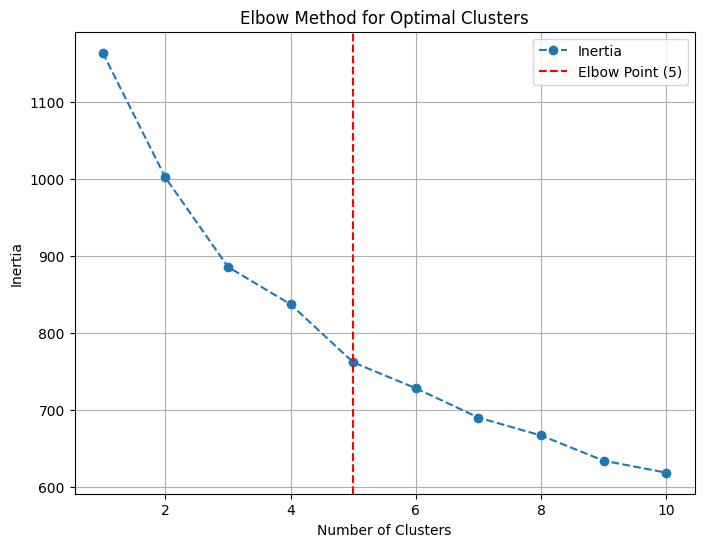

In [ ]:
# Standardize the selected features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_merged[top_features])

# Calculate inertia for different numbers of clusters
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)

# Determine the optimal number of clusters using the elbow method
elbow_point = KneeLocator(range(1, 11), inertia, curve="convex", direction="decreasing").knee
print(f"Optimal number of clusters: {elbow_point}")

# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--', label='Inertia')
plt.axvline(x=elbow_point, color='red', linestyle='--', label=f'Elbow Point ({elbow_point})')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Ensure `data_scaled` includes only top_features and is properly scaled
data_top_features = df_merged[top_features].copy()
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_top_features)

# Perform K-Means clustering
kmeans = KMeans(n_clusters=elbow_point, random_state=42)
df_merged['Cluster'] = kmeans.fit_predict(data_scaled)

# Visualize clusters using the first two top features
# plt.figure(figsize=(8, 6))
# sns.scatterplot(data=df_merged, x=top_features[0], y=top_features[1], hue='Cluster', palette='Set2')
# plt.title("Cluster Visualization (Top Features)")
# plt.xlabel(top_features[0])
# plt.ylabel(top_features[1])
# plt.show()

# PCA for Dimensionality Reduction
pca = PCA(n_components=2)
pca_data = pca.fit_transform(data_scaled)

# Add PCA components to df_merged for PCA-based visualization
df_merged['PCA1'] = pca_data[:, 0]
df_merged['PCA2'] = pca_data[:, 1]

# Visualize clusters using PCA components
# plt.figure(figsize=(8, 6))
# sns.scatterplot(data=df_merged, x='PCA1', y='PCA2', hue='Cluster', palette='Set2')
# plt.title("Cluster Visualization with PCA")
# plt.xlabel("PCA1")
# plt.ylabel("PCA2")
# plt.show()

# Generate Cluster Profile
cluster_profile = df_merged.groupby('Cluster')[top_features].mean()
# print("Cluster Profile (Top Features):")
# print(cluster_profile)

### Classification

In [ ]:
df_merged

,SEQN,RIAGENDR,RIDAGEYR,INDFMPIR,INDHHIN2,DMDEDUC2,DMDHHSIZ,WTMEC2YR,DMDHHSZE,DMQMILIZ,...,LBXWBCSI,LBDHDD,LBXIN,LBXTC,LBXBPB,LBXBCD,LBXBSE,Cluster,PCA1,PCA2
11,73633,0.934450,-1.515341,0.479492,0.0,1.252152,0.0,0.0,-1.274883,0.430416,...,0.168717,-0.536572,-0.163585,0.200333,-0.663780,-0.869900,-0.894446,1,0.444553,-2.524783
55,73816,-1.070149,0.116404,-0.656410,0.0,-0.328918,0.0,0.0,1.107084,0.430416,...,-0.291490,0.225080,-0.050153,1.393307,1.219782,-0.670850,0.751049,2,-1.204136,-0.276714
110,74141,0.934450,0.660319,1.615393,0.0,1.252152,0.0,0.0,-0.083900,0.430416,...,1.135151,0.732847,-0.163254,-1.209544,-0.114129,-0.252844,0.414646,1,2.874363,-0.806565
113,74160,0.934450,0.271808,0.479492,0.0,-0.328918,0.0,0.0,-0.083900,0.430416,...,-0.521594,0.098138,-0.231379,-0.341927,0.086964,-0.730565,-0.684825,0,0.098287,0.102937
127,74253,-1.070149,1.126531,-0.656410,0.0,-0.328918,0.0,0.0,1.107084,0.430416,...,-0.429553,-1.107811,-0.280323,-0.970950,0.321571,0.185067,-0.476689,2,-1.644799,0.001057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1701,83046,0.934450,1.281936,-1.224360,0.0,-1.119454,0.0,0.0,-0.083900,0.430416,...,-0.291490,1.050202,-0.344480,-0.168404,-0.174456,-0.551420,-1.158699,4,-1.463022,1.572434
1740,83297,0.934450,0.971127,-0.088459,0.0,0.461617,0.0,0.0,1.107084,0.430416,...,-0.935780,0.352021,-0.412605,0.287095,-0.288408,0.981268,-0.079715,0,1.630986,1.207494
1763,83429,0.934450,-0.116703,-0.656410,0.0,-0.328918,0.0,0.0,1.107084,0.430416,...,0.490861,0.034667,-0.243946,0.330476,0.375196,-0.173224,0.170583,4,-0.366053,0.078167
1769,83505,0.934450,0.582616,-0.656410,0.0,1.252152,0.0,0.0,1.107084,0.430416,...,-1.257925,1.113673,-0.190372,0.135262,-0.683890,1.001173,1.141490,0,1.601941,1.410142


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np

In [ ]:
target_column = 'RXDRSC1'

X = df_merged.drop(columns=[target_column])  # Drop the target column
y = df_merged[target_column]

X = X.fillna(X.median())

# Encode the target variable if it is categorical
if y.dtype == 'object' or y.dtype.name == 'category':
    y = y.astype('category').cat.codes

In [ ]:
print(y.value_counts())

4    62
0    15
2    15
3     3
5     1
1     1
Name: count, dtype: int64


In [ ]:
# Train-test split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

In [ ]:
# Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division = 0))

print("\nAccuracy Score:", accuracy_score(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Feature Importance
importances = rf_model.feature_importances_
features = X.columns
sorted_indices = np.argsort(importances)[::-1]

print("\nTop 10 Feature Importances:")
for i in range(10):
    print(f"{features[sorted_indices[i]]}: {importances[sorted_indices[i]]:.4f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           4       0.72      0.93      0.81        14
           5       0.00      0.00      0.00         1

    accuracy                           0.65        20
   macro avg       0.14      0.19      0.16        20
weighted avg       0.51      0.65      0.57        20


Accuracy Score: 0.65

Confusion Matrix:
[[ 0  0  1  2  0]
 [ 0  0  0  1  0]
 [ 0  0  0  1  0]
 [ 0  0  1 13  0]
 [ 0  0  0  1  0]]

Top 10 Feature Importances:
DR1TSUGR: 0.0615
LBXTC: 0.0613
LBXBCD: 0.0484
DR1TCALC: 0.0433
PCA2: 0.0416
LBXBSE: 0.0410
DR1TVB6: 0.0395
DR1TCARB: 0.0392
DR1TIRON: 0.0367
DR1TSODI: 0.0346


IndexError: index 4 is out of bounds for axis 1 with size 4

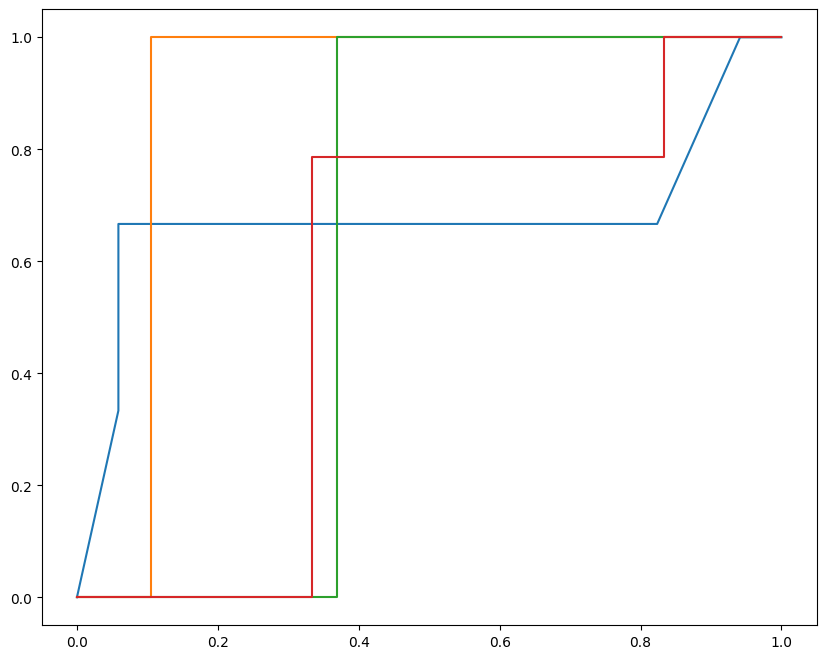

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the labels for multi-class classification
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 4, 5])  # Adjust classes as per your labels
y_pred_prob = rf_model.predict_proba(X_test)

# Initialize plot
plt.figure(figsize=(10, 8))

# Loop through each class to plot ROC curve
num_classes = y_test_bin.shape[1]  # Get number of classes from the shape of y_test_bin
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot the diagonal line (no skill)
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)')

# Set plot attributes
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

plt.show()

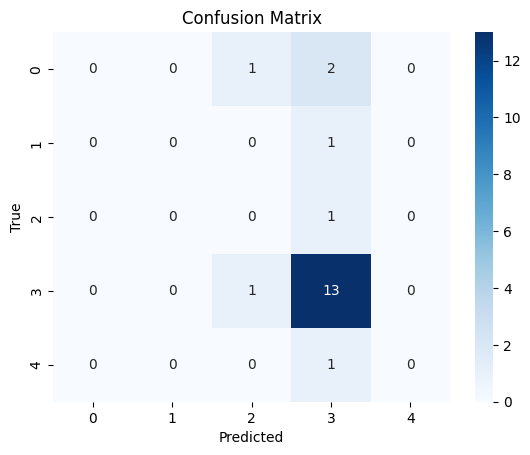

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(len(cm)), yticklabels=range(len(cm)))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Since your model is a multi-class classification problem, the ROC curve needs to be calculated for each class, and you can either plot a separate curve for each class or use a macro-average to summarize the performance.

### Classification to handle class imbalance

In [ ]:
rf_model2 = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model2.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [ ]:
# Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division = 0))

print("\nAccuracy Score:", accuracy_score(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Feature Importance
importances = rf_model2.feature_importances_
features = X.columns
sorted_indices = np.argsort(importances)[::-1]

print("\nTop 10 Feature Importances:")
for i in range(10):
    print(f"{features[sorted_indices[i]]}: {importances[sorted_indices[i]]:.4f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           4       0.72      0.93      0.81        14
           5       0.00      0.00      0.00         1

    accuracy                           0.65        20
   macro avg       0.14      0.19      0.16        20
weighted avg       0.51      0.65      0.57        20


Accuracy Score: 0.65

Confusion Matrix:
[[ 0  0  1  2  0]
 [ 0  0  0  1  0]
 [ 0  0  0  1  0]
 [ 0  0  1 13  0]
 [ 0  0  0  1  0]]

Top 10 Feature Importances:
DR1TVB6: 0.0547
DR1TSFAT: 0.0498
LBDHDD: 0.0472
PCA2: 0.0460
LBXTC: 0.0446
DR1TSUGR: 0.0428
RIDAGEYR: 0.0374
DR1TPOTA: 0.0367
DR1TCALC: 0.0366
LBXIN: 0.0364


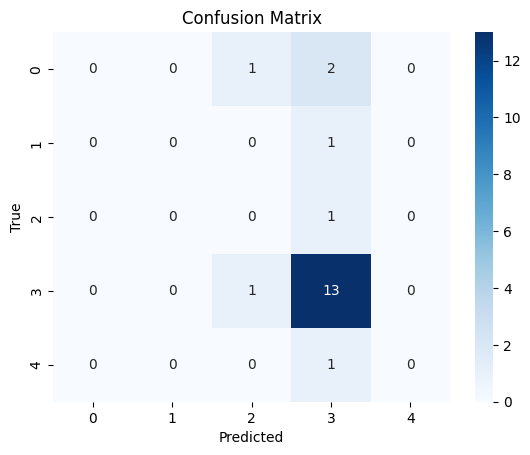

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(len(cm)), yticklabels=range(len(cm)))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

IndexError: index 4 is out of bounds for axis 1 with size 4

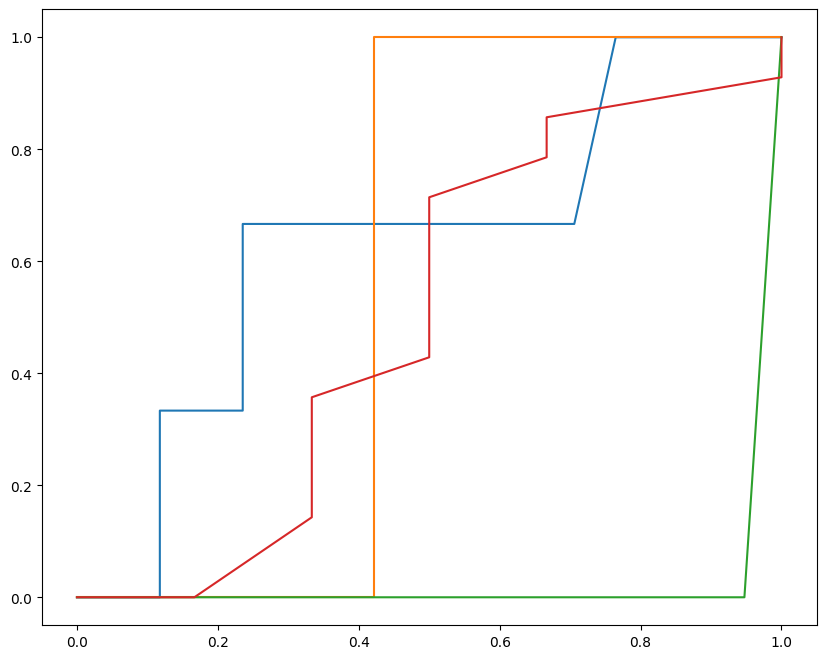

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the labels for multi-class classification
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 4, 5])  # Adjust classes as per your labels
y_pred_prob = rf_model2.predict_proba(X_test)

# Initialize plot
plt.figure(figsize=(10, 8))

# Loop through each class to plot ROC curve
num_classes = y_test_bin.shape[1]  # Get number of classes from the shape of y_test_bin
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot the diagonal line (no skill)
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)')

# Set plot attributes
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

plt.show()